In [1]:
%matplotlib inline

In [2]:
from thetis import *
from firedrake_adjoint import *

In [3]:
import adolc
import matplotlib.pyplot as plt
import numpy as np

In [4]:
from adapt_utils.case_studies.tohoku.options.okada_options import TohokuOkadaBasisOptions
from adapt_utils.unsteady.solver import AdaptiveProblem
from adapt_utils.unsteady.solver_adjoint import AdaptiveDiscreteAdjointProblem

# Computing the gradient of timeseries misfit w.r.t. Okada parameters

In this work we compute gradients of quantities of interest of the form

$$
    J(\mathbf u,\eta;\mathbf m)
    =\int_0^T\int_\Omega\sum_{g\in\mathcal G}\mathbb1_g(\eta-\eta_g)^2\;\mathrm dx\;\mathrm dt,
$$

where $\mathcal G$ is a set of gauges and associated with gauge $g\in\mathcal G$ are free surface measurements $\eta_g$ and a neighbourhood indicator function $\mathbb1_g$.
Here $\mathbf m$ is a vector of control parameters which define the tsunami source.

In this notebook, $\mathbf m$ contains parameters associated with an Okada function representation on an array of subfaults.
That is, the initial surface elevation $\eta_0$ is given by

$$
    \eta_0(\mathbf x)=\mathrm{Okada}(\mathbf m),
$$

where $\mathrm{Okada}$ denotes the Okada model. This is then passed to a shallow water forward propagation model as an initial condition:

$$
    \mathbf u(\mathbf x,0)=\boldsymbol0,\quad
    \eta(\mathbf x,0)=\eta_0(\mathbf x).
$$

We can use `pyadjoint` to compute the gradient of $J$ with respect to this initial surface, or to solve the discrete adjoint problem.
In particular, it can give us the adjoint solution at the initial time, $\eta^*(\mathbf x,0)$, for a given $\eta_0$.

We can use `pyadolc` to differentiate through the Okada model, giving

$$
    \frac{\mathrm d\eta_0}{\mathrm d\mathrm m}\:\widetilde{\mathrm m},
$$

for some choice of control parameters, $\widetilde{\mathrm m}$.

Let $\Pi$ be a linear interpolation operator from the Okada grid to the mesh used in the tsunami propagation.
Then the action of the gradient on $\widetilde{\mathrm m}$ is given by

$$
    \frac{\mathrm dJ}{\mathrm d\mathrm m}\:\widetilde{\mathrm m}=
    \int_\Omega\eta^*(\mathbf x,0)\:\Pi\left(
        \frac{\mathrm d\eta_0}{\mathrm d\mathrm m}\:\widetilde{\mathrm m}
    \right)\;\mathrm dx.
$$

If we naively sequentially choose $\widetilde{\mathrm m}$ to be correspond to the unit vectors $\mathbf e_k$ up to the dimension of the control space, notice that we are able to recover the gradient.
Of course, there are far more efficient ways of doing this, as we shall see.

### Initialisation

Set parameters and create a `TohokuOkadaBasisOptions` object to hold them

In [5]:
kwargs = {
    'level': 0,
    'synthetic': True,
    'plot_pvd': False,
    'save_timeseries': True,
    'family': 'dg-cg',
    'stabilisation': None,
    'okada_grid_resolution': 51,
    'debug': False,
}
plotting_kwargs = {
    'cmap': 'coolwarm',
    'levels': 50,
}
nonlinear = False

In [6]:
op = TohokuOkadaBasisOptions(**kwargs)

In [7]:
class DiscreteAdjointTsunamiProblem(AdaptiveDiscreteAdjointProblem):
    """The subclass exists to pass the QoI as required."""
    def quantity_of_interest(self):
        return self.op.J

### Get timeseries data

We use a 'synthetic' approach whereby 'the truth' is given by timeseries extracted from a model run with some Okada parameters.

In [8]:
with stop_annotating():
    swp = AdaptiveProblem(op, nonlinear=nonlinear, print_progress=False)
    swp.solve_forward()  # NOTE: pyadolc annotation is also off
    for gauge in op.gauges:
        op.gauges[gauge]["data"] = op.gauges[gauge]["timeseries"]

Perturb the control parameters with some Normal random noise so that the source is different from that used to generate the gauge timeseries data.

In [9]:
kwargs['control_parameters'] = op.control_parameters
mu = 0
sigma = 5
for control in op.active_controls:
    size = np.shape(op.control_parameters[control])
    kwargs['control_parameters'][control] += np.random.normal(loc=mu, scale=sigma, size=size)
op_opt = TohokuOkadaBasisOptions(**kwargs)
for gauge in op_opt.gauges:
    op_opt.gauges[gauge]["data"] = op.gauges[gauge]["data"]

### Differentatiate the source model

When setting the free surface initial condition using the Okada model, we tell `pyadolc` to annotate its tape.

In [10]:
tape_tag = 0
swp = DiscreteAdjointTsunamiProblem(op_opt, nonlinear=nonlinear, print_progress=False)
swp.set_initial_condition(annotate_source=True, tag=tape_tag)

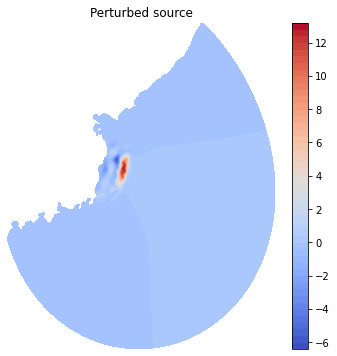

In [11]:
fig, axes = plt.subplots(figsize=(6, 6))
eta = swp.fwd_solutions[0].split()[1].copy(deepcopy=True)
fig.colorbar(tricontourf(eta, axes=axes, **plotting_kwargs), ax=axes);
axes.axis(False);
axes.set_title("Perturbed source");

The naive approach to computing a Jacobian is to propagate each unit vector, or equivalently the identity matrix of the same dimension as the inputs, through the forward mode of AD.
This is a very large ($N^2\times N^2$) identity matrix!
We can do better by establishing which entries are independent and then constructing an appropriate *seed matrix* of dimension $N^2\times k$, where (we hope) $k\ll N^2$.

In the AD literature, $k$ is usually referred to as the number of *colours*.
This is because of the graph colouring routines used under the hood.
In the case of `ADOL-C`, the graph colouring package is called `ColPack`.

Let's look at the sparsity pattern for first order derivatives to establish what the seed matrices need to look like.

In [14]:
op_opt.get_input_vector()
jacobian_pattern = adolc.sparse.jac_pat(tape_tag, op_opt.input_vector, options=[0, 0, 0, 0])

In [15]:
l = 3
N2 = op.N**2
m, n = np.shape(jacobian_pattern)
msg = "row {:6d}: {:}"
for i, row in enumerate(jacobian_pattern):
    if 0 <= i < l or N2 - l <= i < N2:
        print(msg.format(i, row))
    elif N2 <= i < N2 + l or (2*N2 - l <= i < 2*N2):
        print(msg.format(i, row))
    elif 2*N2 <= i < 2*N2 + l:
        print(msg.format(i, row))
    elif i in (l, N2 + l, 2*N2 + l):
        print(14*" " + "...")
    elif m - N2 <= i < m - N2 + l or (m - l <= i < m):
        print(msg.format(i, row))

row      0: [0, 1, 2, 3]
row      1: [0, 1, 2, 3]
row      2: [0, 1, 2, 3]
              ...
row   2598: [0, 1, 2, 3]
row   2599: [0, 1, 2, 3]
row   2600: [0, 1, 2, 3]
row   2601: [4, 5, 6, 7]
row   2602: [4, 5, 6, 7]
row   2603: [4, 5, 6, 7]
              ...
row   5199: [4, 5, 6, 7]
row   5200: [4, 5, 6, 7]
row   5201: [4, 5, 6, 7]
row   5202: [8, 9, 10, 11]
row   5203: [8, 9, 10, 11]
row   5204: [8, 9, 10, 11]
              ...
row 491589: [756, 757, 758, 759]
row 491590: [756, 757, 758, 759]
row 491591: [756, 757, 758, 759]
row 494187: [756, 757, 758, 759]
row 494188: [756, 757, 758, 759]
row 494189: [756, 757, 758, 759]


In [16]:
del jacobian_pattern

We observe what we already knew!
The first $N^2$ rows of the output (i.e. those based on the first subfault) depend only on the first four active control parameters (i.e. the ones defined on that subfault).
The same goes for the next $N^2$, and so on.

Because of this independence, we can safely propagate the following vectors and receive no cross terms:

$$
    \mathbf e_{\mathrm{slip}} = \sum_{i=0}^{\mathrm{\# subfaults}} \mathbf e_{4i},\quad
    \mathbf e_{\mathrm{rake}} = \sum_{i=0}^{\mathrm{\# subfaults}} \mathbf e_{4i+1},\quad
    \mathbf e_{\mathrm{strike}} = \sum_{i=0}^{\mathrm{\# subfaults}} \mathbf e_{4i+2},\quad
    \mathbf e_{\mathrm{dip}} = \sum_{i=0}^{\mathrm{\# subfaults}} \mathbf e_{4i+3}.
$$

That is, there are just four colours, each corresponding to one type of control parameter.

In [12]:
op_opt.get_seed_matrices()  # This does what is discussed above
F, dFdm = adolc.fov_forward(tape_tag, op_opt.input_vector, op_opt.seed_matrices)
N = op.N
F = F.reshape(190, N, N)
F = sum(F[i, :, :] for i in range(190))
dFdm = dFdm.reshape(190, N, N, 4)
print(dFdm.shape)

(190, 51, 51, 4)


Check that the function stored to tape evaluates as it should

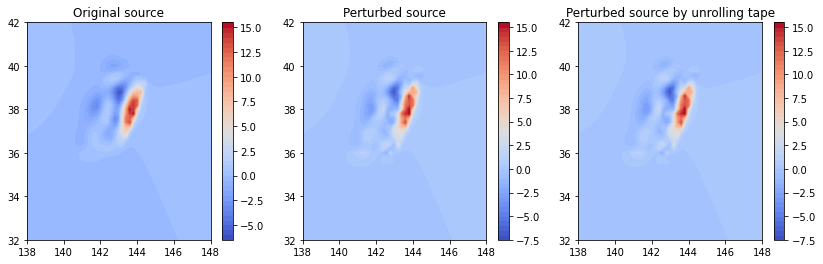

In [13]:
fig, axes = plt.subplots(ncols=3, figsize=(14, 4))
X = op.fault.dtopo.X
Y = op.fault.dtopo.Y
dZ = op.fault.dtopo.dZ.reshape(N, N)
dZ_pert = op_opt.fault.dtopo.dZ.reshape(N, N)
fig.colorbar(axes[0].contourf(X, Y, dZ, **plotting_kwargs), ax=axes[0]);
axes[0].set_title("Original source");
fig.colorbar(axes[1].contourf(X, Y, dZ_pert, **plotting_kwargs), ax=axes[1]);
axes[1].set_title("Perturbed source");
fig.colorbar(axes[2].contourf(X, Y, F, **plotting_kwargs), ax=axes[2]);
axes[2].set_title("Perturbed source by unrolling tape");

### Establish interpolation operator from Okada grid to mesh used for tsunami propagation

Creating the Okada mesh is easy: just use `Firedrake`'s utility meshes.
Note that the first two arguments to `SquareMesh` are the number of *cells* in each direction, whereas `N` is the number of *vertices*.

In [14]:
op_opt.get_interpolation_operators()

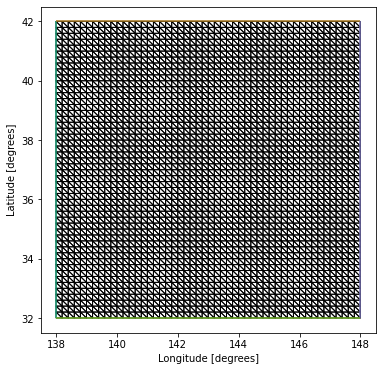

In [15]:
fig, axes = plt.subplots(figsize=(6, 6))
triplot(op_opt.okada_mesh, axes=axes);
axes.set_xlabel("Longitude [degrees]");
axes.set_ylabel("Latitude [degrees]");

In [16]:
F_proj = op_opt.interpolate_okada_array(F)

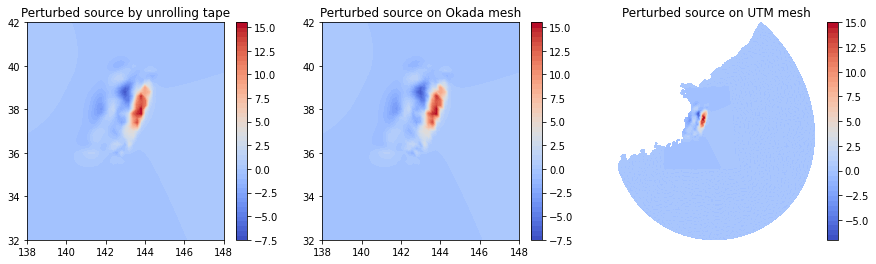

In [18]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))

fig.colorbar(axes[0].contourf(X, Y, F, **plotting_kwargs), ax=axes[0]);
axes[0].set_title("Perturbed source by unrolling tape");
fig.colorbar(tricontourf(op_opt.source_okada, axes=axes[1], **plotting_kwargs), ax=axes[1]);
axes[1].set_title("Perturbed source on Okada mesh");
fig.colorbar(tricontourf(F_proj, axes=axes[2], **plotting_kwargs), ax=axes[2]);
axes[2].set_title("Perturbed source on UTM mesh");
axes[2].axis(False);

We expect the first and second plots to be identical.
They are *almost* identical.
It seems that the difference is actually a plotting artefact.
If you use quadrilateral meshes then there is almost no difference.

### Solve forward and adjoint tsunami model

Now that we have timeseries data, we can run the forward model with some initial guess parameter choices and compare the resulting timeseries against them.
In this case the initial guess is given by adding some Normal random noise to the original parameters.

During the forward run, `pyadjoint` also annotates its own tape, allowing us to later solve the adjoint problem.
Store the initial condition so that it may be interpreted as a control by `pyadjoint` and then solve forward.

In [19]:
source_control = Control(swp.fwd_solutions[0])
swp.setup_solver_forward(0)
swp.solve_forward_step(0)
print("QoI: {:.4e}".format(op_opt.J))

QoI: 1.4359e+05


Compute the gradient and extract the adjoint solution at time $t=0$.

In [20]:
swp.compute_gradient(source_control)
swp.get_solve_blocks()
swp.extract_adjoint_solution(0)
u_star, eta_star = swp.adj_solutions[0].split()

 0   ADJOINT EXTRACT mesh  1/ 1  time     0.00


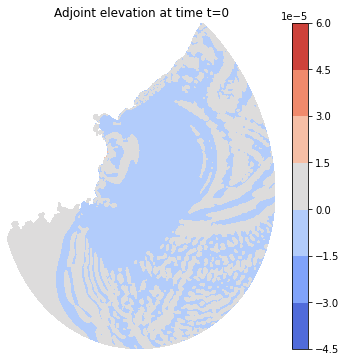

In [21]:
fig, axes = plt.subplots(figsize=(6, 6))
fig.colorbar(tricontourf(eta_star, axes=axes, cmap='coolwarm'), ax=axes);
axes.axis(False);
axes.set_title("Adjoint elevation at time t=0");

### Apply the chain rule

We are now set to be able to compute the gradient of $J$ with respect to the Okada parameters!

Component of dJdm: 8.4957e+00
Component of dJdm: 1.5840e-01
Component of dJdm: -1.1769e+00
Component of dJdm: -1.9102e+00


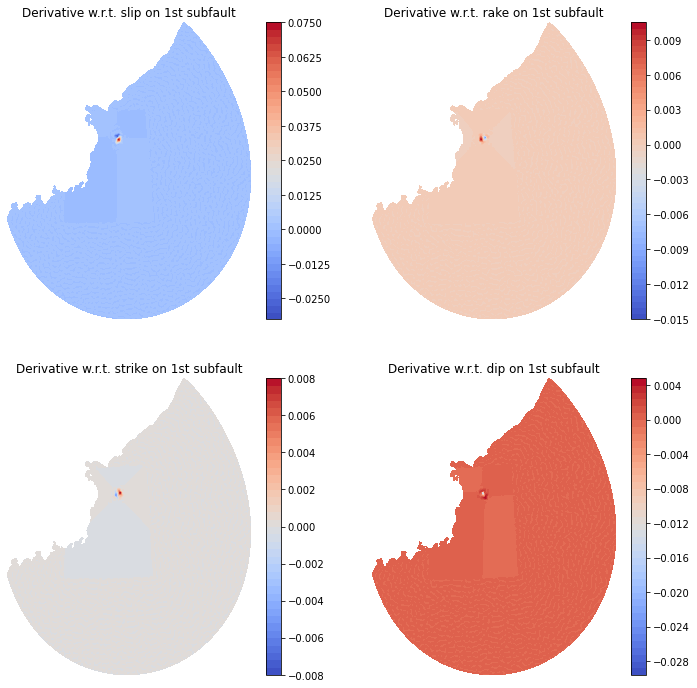

In [22]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 12))

for j in range(4):
    deta0dm = op_opt.interpolate_okada_array(dFdm[0, :, :, j])
    
    ax = axes[j // 2, j % 2]
    fig.colorbar(tricontourf(deta0dm, axes=ax, **plotting_kwargs), ax=ax);
    ax.set_title("Derivative w.r.t. {:s} on 1st subfault".format(op.active_controls[j]));
    ax.axis(False);
    
    print("Component of dJdm: {:.4e}".format(assemble(eta_star*deta0dm*dx)))

In [23]:
dJdm = np.zeros((op.nx*op.ny, 4))
print("dJdm = [")
for i in range(op.nx*op.ny):
    for j in range(4):
        deta0dm = op_opt.interpolate_okada_array(dFdm[i, :, :, j])
        dJdm[i, j] = assemble(eta_star*deta0dm*dx)
    print("    {:8.4f}, {:8.4f}, {:8.4f}, {:8.4f}".format(*dJdm[i, :]))
print("]")

dJdm = [
      8.4957,   0.1584,  -1.1769,  -1.9102
      9.9057,  -0.7661,  -0.1134,   2.4172
     -1.5587,   1.3505,  -1.1814,  -2.9465
     -6.5768, -11.0695,  13.7213,  39.6340
     16.2921,  -9.5128, -10.0426,  69.3528
    -34.7871, -21.4404,  43.4594, 145.4488
    -56.5930,   0.3683, -38.4296, 251.1623
     20.5683,   5.1498,  15.9630, 175.7936
     22.1291,  30.1202, -27.6266, 206.6625
    -49.5919,  29.8631, -36.1376,  80.2081
     -0.0547,  16.6251,  -5.5978,  69.8421
    -24.3662,   6.5833,  -6.0016,  29.2852
    -28.6587,   4.3864,  -4.5780,   1.6869
    -15.7267,   2.3596,  -2.3500,  -2.1674
     -1.8259,   1.3496,  -1.1208,  -9.1225
      2.2343,  -0.5425,   1.1680,  -8.7709
      3.1285,  -0.0271,   0.1546,  -1.4245
      2.0724,   0.0349,  -0.1576,   1.5352
      0.2344,  -0.1120,   0.0756,  -0.1325
     16.2636,  -0.7787,  -0.3769,  -2.1213
     28.4000,   0.8537,  -0.2397,   1.5767
     59.9666,  -5.6665,   5.6215,   9.4239
    109.6383, -25.3199,  24.8456,  54.0548
  

There we have it: the gradient of the timeseries misfit QoI with respect to an array of slip, rake, strike and dip parameters!
We can now use it in gradient-based optimisation routines for source inversion.
However, before we do so we should perform a Taylor test _-> see the next notebook_.